py -3.10 -m venv .astrovenv310
.\.astrovenv310\Scripts\Activate.ps1
python.exe -m pip install --upgrade pip

pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

pip install matplotlib



ENVIRONMENT CHECK

In [1]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA verfügbar:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0))


PyTorch Version: 2.5.1+cu121
CUDA verfügbar: True
CUDA Version: 12.1
GPU: Quadro RTX 5000


BILDVORBEREITUNG DATASET

In [2]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import os

PATH = 'F:/_AI/_ARBEIT/astroenv/'

class HubbleDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = [
            f for f in os.listdir(img_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")  # sicherstellen, dass es RGB ist
        if self.transform:
            image = self.transform(image)
        return image

# Transformation definieren
transform = transforms.Compose([
    transforms.Resize((128, 128)),      # runterrechnen für schnelles Training
    transforms.CenterCrop(128),         # falls ungleichmäßig
    transforms.ToTensor(),              # in PyTorch Tensor [0,1]
    transforms.Normalize([0.5]*3, [0.5]*3)  # in [-1,1] normalisieren für GANs/VAEs
])

# Dataset laden
dataset = HubbleDataset(f"{PATH}data/esa_hubble/galaxies", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [14]:
import os

folder_path = f"{PATH}data/esa_hubble/galaxies"

image_count = len([f for f in os.listdir(folder_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))])

print(f"Number of images: {image_count}")

Number of images: 240


VORSCHAU

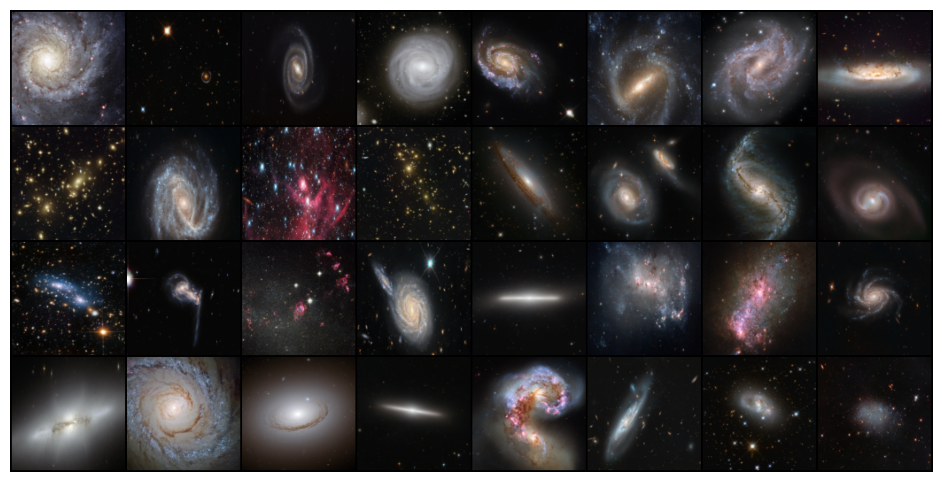

In [3]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Ein Batch aus dem Loader holen
data_iter = iter(dataloader)
images = next(data_iter)

# In Grid anzeigen (aus [-1, 1] zurück nach [0, 1])
grid = vutils.make_grid(images, nrow=8, normalize=True)
plt.figure(figsize=(12, 6))
plt.axis("off")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

Encoder: Komprimiert das Bild in eine latente Repräsentation (z. B. 64-dim).

Decoder: Baut daraus wieder ein Bild auf.

Ziel: Input ≈ Output, trotz Datenreduktion → das Modell lernt wichtige Muster in den Bildern (z. B. Nebelstrukturen).

Modell: Autoencoder (CNN-basiert, für 128×128 RGB)

In [4]:
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 128 → 64
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 64 → 32
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 32 → 16
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # 16 → 8
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(256*8*8, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256*8*8),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 8 → 16
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 16 → 32
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # 32 → 64
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),    # 64 → 128
            nn.Tanh()  # output ∈ [-1, 1] wegen Normalize
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


TRAINING

In [5]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.utils as vutils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 200

for epoch in range(num_epochs):
    for imgs in dataloader:  # dein ESA-Hubble-Dataloader
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    
    # Optionale Visualisierung
    with torch.no_grad():
        out_imgs = model(imgs[:8])
        grid = vutils.make_grid(out_imgs, nrow=4, normalize=True)
        vutils.save_image(grid, f"{PATH}output/epoch_{epoch+1:02d}.png")

cuda
Epoch [1/200], Loss: 0.2957
Epoch [2/200], Loss: 0.1648
Epoch [3/200], Loss: 0.0681
Epoch [4/200], Loss: 0.0751
Epoch [5/200], Loss: 0.0489
Epoch [6/200], Loss: 0.0510
Epoch [7/200], Loss: 0.0526
Epoch [8/200], Loss: 0.0497
Epoch [9/200], Loss: 0.0422
Epoch [10/200], Loss: 0.0398
Epoch [11/200], Loss: 0.0325
Epoch [12/200], Loss: 0.0344
Epoch [13/200], Loss: 0.0264
Epoch [14/200], Loss: 0.0312
Epoch [15/200], Loss: 0.0262
Epoch [16/200], Loss: 0.0275
Epoch [17/200], Loss: 0.0324
Epoch [18/200], Loss: 0.0320
Epoch [19/200], Loss: 0.0229
Epoch [20/200], Loss: 0.0226
Epoch [21/200], Loss: 0.0232
Epoch [22/200], Loss: 0.0266
Epoch [23/200], Loss: 0.0277
Epoch [24/200], Loss: 0.0209
Epoch [25/200], Loss: 0.0224
Epoch [26/200], Loss: 0.0232
Epoch [27/200], Loss: 0.0212
Epoch [28/200], Loss: 0.0168
Epoch [29/200], Loss: 0.0154
Epoch [30/200], Loss: 0.0162
Epoch [31/200], Loss: 0.0220
Epoch [32/200], Loss: 0.0160
Epoch [33/200], Loss: 0.0140
Epoch [34/200], Loss: 0.0144
Epoch [35/200], Lo

In [6]:
# Input vs. Output plotten

def show_input_output(model, dataloader, device, n=8):
    model.eval()
    with torch.no_grad():
        imgs = next(iter(dataloader))[:n]  # n Bilder laden
        imgs = imgs.to(device)

        recon = model(imgs)

        # Rückskalieren von [-1,1] auf [0,1] (falls normalize verwendet wurde)
        imgs = (imgs + 1) / 2
        recon = (recon + 1) / 2

        fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
        for i in range(n):
            axes[0, i].imshow(imgs[i].permute(1, 2, 0).cpu().numpy())
            axes[0, i].axis('off')
            axes[0, i].set_title("Input")

            axes[1, i].imshow(recon[i].permute(1, 2, 0).cpu().numpy())
            axes[1, i].axis('off')
            axes[1, i].set_title("Output")

        plt.tight_layout()
        plt.show()


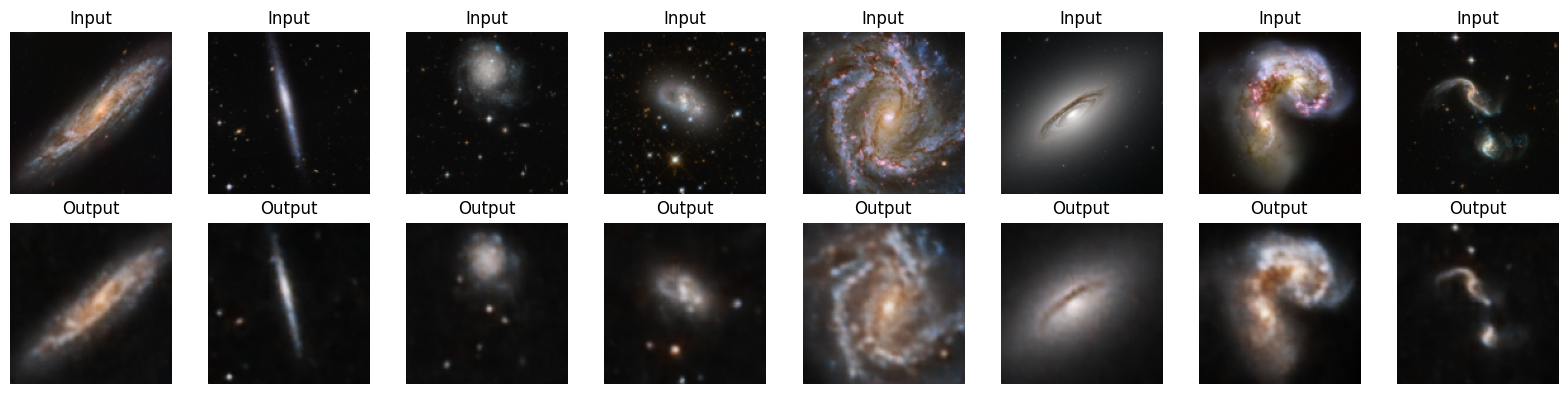

In [7]:
show_input_output(model, dataloader, device)

In [8]:
# Speichern der Gewichte (nach Training)
torch.save(model.state_dict(), f'{PATH}/models/ConvAutoencoder_{num_epochs}th_epoch.pth')

In [9]:

# Laden der Gewichte (später oder in neuer Session)
model = ConvAutoencoder().to(device)  # gleiche Struktur wie beim Training
model.load_state_dict(torch.load(f'{PATH}/models/ConvAutoencoder_{num_epochs}th_epoch.pth'))
model.eval() # für prediction

C:\Users\AI_3Dom_Studios\AppData\Local\Temp\ipykernel_18044\1086684722.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{PATH}/models/C

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=16384, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=16384, bias=True)
    (1): ReLU(inplace=True)
    (2): Unflatten(dim=1, unflattened_size=(256, 8, 8))
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(64, 32, ker

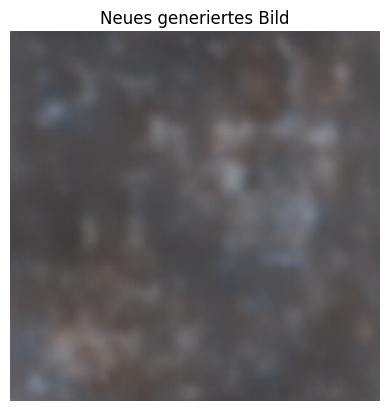

In [ ]:
# Neue Bilder generieren zufaellige vector z RESULTAT FLACH

seed = 23456  # beliebige Zahl
torch.manual_seed(seed)

# Zufälligen latenten Vektor erzeugen
latent_dim = 64
z = torch.randn(1, latent_dim).to(device)

# Neues Bild generieren
new_img = model.decoder(z)

# Bild anzeigen
plt.imshow(((new_img[0] + 1) / 2).permute(1, 2, 0).cpu().detach().numpy())
plt.axis('off')
plt.title("Neues generiertes Bild")
plt.show()

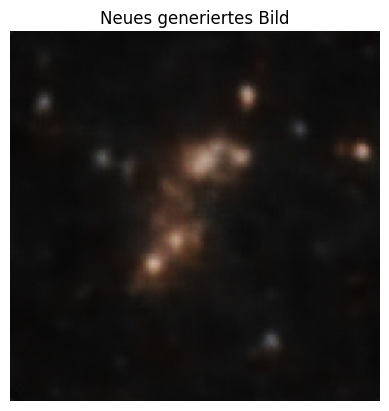

In [ ]:
# Neue Bilder generieren vector z aus dem Datensatz AENDERE DIE MULTIPLICATION FACTOR IN # leichte Variation
seed = 42  # beliebige Zahl
torch.manual_seed(seed)

# Zufälligen latenten Vektor erzeugen
latent_dim = 64
# 1. Sampling aus echten Bildern Statt rein zufälliger z, nimm z-Vektoren von echten Bildern:
real_img = next(iter(dataloader))  # Beispielbild laden
z = model.encoder(real_img[0:1].to(device))  # Latenter Vektor vom echten Bild
z = z + torch.randn_like(z) * 0.1  # leichte Variation
new_img = model.decoder(z)  # Rekonstruktion




# Bild anzeigen
plt.imshow(((new_img[0] + 1) / 2).permute(1, 2, 0).cpu().detach().numpy())
plt.axis('off')
plt.title("Neues generiertes Bild")
plt.show()

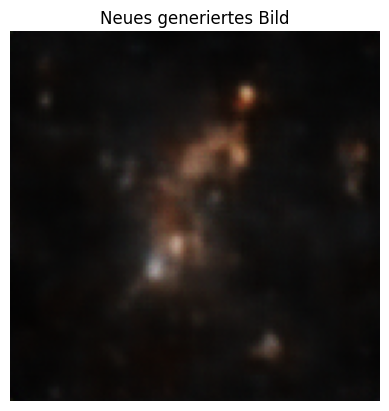

In [21]:
seed = 42  # beliebige Zahl
torch.manual_seed(seed)

# Zufälligen latenten Vektor erzeugen
latent_dim = 64
# 1. Sampling aus echten Bildern Statt rein zufälliger z, nimm z-Vektoren von echten Bildern:
real_img = next(iter(dataloader))  # Beispielbild laden
z = model.encoder(real_img[0:1].to(device))  # Latenter Vektor vom echten Bild
z = z + torch.randn_like(z) * 2  # leichte Variation
new_img = model.decoder(z)  # Rekonstruktion




# Bild anzeigen
plt.imshow(((new_img[0] + 1) / 2).permute(1, 2, 0).cpu().detach().numpy())
plt.axis('off')
plt.title("Neues generiertes Bild")
plt.show()

In [25]:
galaxy_names = [
    "Crimson Spiral",
    "Void Lantern",
    "Nebularkiss",
    "Quantum Bloom",
    "Andromeda Echo",
    "Stellar Dagger",
    "Dark Mirage",
    "Plasma Veil",
    "Celestial Drift",
    "Luminous Coil",
    "Vortex Crown",
    "Ghost Arc",
    "Halo Shard",
    "Silent Nova",
    "Sapphire Rift",
    "Eclipse Spire",
    "Ember Halo",
    "Chrono Bloom",
    "Obsidian Whirlpool",
    "Aurora Core",
    "Gravity Lace",
    "Whispering Cluster",
    "Ion Fang",
    "Spectral Blossom"
]

In [26]:
# Bild als NumPy-Array speichern
import random

import numpy as np
from PIL import Image
import torch

galaxy_name = galaxy_names[0]
# Nach der Generierung
img_tensor = new_img[0]  # [C, H, W]
img_np = ((img_tensor + 1) / 2).cpu().detach().numpy()  # Werte in [0, 1]

# Optional: Größe anpassen (kleiner für Volumen)
img_np = np.transpose(img_np, (1, 2, 0))  # [H, W, C]
h, w, c = img_np.shape

# In 3D extrudieren → (z. B. 32 Schichten = Tiefe)
depth = 32
volume = np.repeat(img_np[np.newaxis, :, :, :], depth, axis=0)  # [D, H, W, C]

# Speichern als .npz
np.savez(f"{PATH}/hou/{galaxy_name}_latent_volume.npz", volume=volume)

HOUDINI VDB VISUALIZATION

In [ ]:
import numpy as np
import hou

# Pfad zum .npz File (anpassen)
npz_path = "D:/_AI/_ARBEIT/astroenv/hou/Crimson Spiral_latent_volume.npz"

# Lade das npz File
data = np.load(npz_path)

# Beispiel: 3D-Density Array aus dem 'latent' Schlüssel laden
# Wir nehmen nur den ersten Channel (Index 0), falls 4D Array
latent = data['latent']  # Shape z.B. (8,8,8,16) oder (dim_x, dim_y, dim_z, channels)

if latent.ndim == 4:
    density_data = latent[:, :, :, 0]  # nur erster Channel als Density
elif latent.ndim == 3:
    density_data = latent
else:
    raise ValueError("Unerwartete Array-Dimension")

# Houdini: VDB Volume erstellen
geo = hou.pwd().geometry()

# Volumen-Dimensionen
dim_x, dim_y, dim_z = density_data.shape

# VDB Resolution (je nach Gridgröße)
voxel_size = 1.0

# Erstelle neues VDB Volume (SDF Typ 'fog' für Density)
vdb = hou.FloatVolume.create(geo, (dim_x, dim_y, dim_z), voxel_size, "density")

# Fülle VDB mit Werten aus numpy Array
vals = vdb.allVoxelIndices()

for idx in vals:
    x, y, z = idx
    vdb.setVoxel(idx, float(density_data[x, y, z]))

# VDB ins Geo setzen
geo.addVolume(vdb)

print("VDB Volume aus .npz erfolgreich erzeugt!")
